In [11]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import shap
import warnings
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
hu_data = pd.read_csv(r'C:\Users\12045\Desktop\户数据(预处理后).csv')
X = hu_data.drop(columns=['zcgdarea'])
y = hu_data['zcgdarea']

In [12]:
# 方差选择法 
threshold = 0.5
selector_variance = VarianceThreshold(threshold=threshold)
X_selected_variance = selector_variance.fit_transform(X)
selected_features_variance = X.columns[selector_variance.get_support()]

# L1正则法
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X, y)
# 获取系数非零的特征
selected_features_lasso = X.columns[lasso.coef_ != 0]

# 互信息
from sklearn.feature_selection import mutual_info_regression
# 计算特征与目标变量的互信息
mi_scores = mutual_info_regression(X, y)
# 选择互信息得分较高的特征
selected_features_mi = X.columns[np.argsort(mi_scores)[-5:]]

# 随机森林
model_tree = RandomForestRegressor()
model_tree.fit(X, y)
# 获取特征重要性
feature_importances = model_tree.feature_importances_
# 选择重要性较高的特征
threshold_tree = 0.01  # 假设选择重要性大于0.01的特征
selected_features_tree = X.columns[feature_importances > threshold_tree]

# 相关系数法
# 这里以绝对值相关系数大于阈值作为特征选择标准
threshold_correlation = 0.5  # 设定阈值
correlation_matrix = X.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
selected_features_correlation = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold_correlation)]

# 将所有特征子集整合到一个集合中
all_feature_sets = []
all_feature_sets.extend(selected_features_variance)
all_feature_sets.extend(selected_features_tree)
all_feature_sets.extend(selected_features_lasso)
all_feature_sets.extend(selected_features_correlation)
all_feature_sets.extend(selected_features_mi)

# 计算每个特征子集的重叠次数
overlap_counts = {}
for feature_set in all_feature_sets:
    if feature_set in overlap_counts:
        overlap_counts[feature_set] += 1
    else:
        overlap_counts[feature_set] = 1

# 找到重叠次数大于等于1的特征子集
min_overlap_count = 1
selected_feature_sets = [feature_set for feature_set, count in overlap_counts.items() if count >= min_overlap_count]

print("重叠次数大于等于1的特征子集:")
for feature_set in selected_feature_sets:
    print(feature_set)
print("重叠次数:", min_overlap_count)

重叠次数大于等于1的特征子集:
hid
year
chengbaogd
chengbaogdks
jygdarea
jycbgdarea
jyczgdarea
jynhgdarea
jygdnum
jygdnum1
jygdnum5
zcgdksnum
zcqiyearea
zchezuoshearea
zccunjitiarea
zcnonghuarea
zcwainonghuarea
zcareahetong
zcareaqixian
jitizcarea
jitizcareacgb
jitizcareazj
zcareashouzu
zujin
cbdfangwei
cbdarea
cbdcwjuli
cbddljuli
c_chengbaogd
x_chengbaogd
s_chengbaogd
cychengbaogd
重叠次数: 1


In [13]:
# 选取目标列和特征列，划分数据集
selected_feature = ['zujin', 'cbdcwjuli', 'cbddljuli', 'jygdnum', 'jygdnum1', 'jygdnum5', 'jyczgdarea',
                     ]

X = hu_data[selected_feature]

# 将数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# 线性回归

# 初始化线性回归模型
model = LinearRegression()
# 在训练集上训练模型
model.fit(X_train, y_train)
# 在测试集上进行预测
y_pred = model.predict(X_test)

# 输出模型的系数
coefficients = pd.DataFrame({'Variable': X.columns, 'Coefficient': model.coef_})
print("\nCoefficients:\n", coefficients)

# 计算各项指标
print('\n线性回归模型各项指标:')
mse = mean_squared_error(y_test, y_pred)
print("均方误差（MSE）:", mse)
mae = mean_absolute_error(y_test, y_pred)
print("平均绝对误差（MAE）:", mae)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)


Coefficients:
      Variable  Coefficient
0       zujin     0.636659
1   cbdcwjuli     0.011316
2   cbddljuli     0.006656
3     jygdnum    -0.000215
4    jygdnum1    -0.006341
5    jygdnum5    -0.000120
6  jyczgdarea     0.000333

线性回归模型各项指标:
均方误差（MSE）: 0.7078642528608499
平均绝对误差（MAE）: 0.44038326108221815
R-squared: 0.33041068872721335


In [21]:
# 随机森林
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# 定义目标函数
def evaluate_rf(n_estimators, max_depth, min_samples_split):
    # 创建随机森林模型
    rf_model = RandomForestRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        random_state=42
    )
    # 进行交叉验证
    scores = -cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    # 返回负均方误差的均值（贝叶斯优化最小化目标）
    return scores.mean()
# 定义超参数搜索空间
pbounds = {'n_estimators': (50, 100),
           'max_depth': (5, 10),
           'min_samples_split': (5, 10)}
# 初始化贝叶斯优化搜索
bayesian_opt = BayesianOptimization(
    f=evaluate_rf,
    pbounds=pbounds,
    random_state=42
)
# 开始贝叶斯优化搜索
print("正在使用贝叶斯优化搜索最佳参数...")
bayesian_opt.maximize(init_points=10, n_iter=50)
# 输出最佳参数
best_params = bayesian_opt.max
print("最佳参数:", best_params)
# 使用最佳参数的模型进行预测
best_rf_model = RandomForestRegressor(
    n_estimators=int(best_params['params']['n_estimators']),
    max_depth=int(best_params['params']['max_depth']),
    min_samples_split=int(best_params['params']['min_samples_split']),
    random_state=42
)
best_rf_model.fit(X_train, y_train)  # 拟合训练集
y_pred = best_rf_model.predict(X_test)
print("\n随机森林模型各项误差指标")
mse = mean_squared_error(y_test, y_pred)
print("均方误差（MSE）:", mse)
mae = mean_absolute_error(y_test, y_pred)
print("平均绝对误差（MAE）:", mae)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2, '\n')

正在使用贝叶斯优化搜索最佳参数...
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.356     | 6.873     | 9.754     | 86.6      |
| 2         | 0.3685    | 7.993     | 5.78      | 57.8      |
| 3         | 0.3521    | 5.29      | 9.331     | 80.06     |
| 4         | 0.3694    | 8.54      | 5.103     | 98.5      |
| 5         | 0.3674    | 9.162     | 6.062     | 59.09     |
| 6         | 0.3551    | 5.917     | 6.521     | 76.24     |
| 7         | 0.367     | 7.16      | 6.456     | 80.59     |
| 8         | 0.3567    | 5.697     | 6.461     | 68.32     |
| 9         | 0.3608    | 7.28      | 8.926     | 59.98     |
| 10        | 0.3645    | 7.571     | 7.962     | 52.32     |
| 11        | 0.3675    | 9.284     | 6.831     | 98.95     |
| 12        | 0.3534    | 5.83      | 5.976     | 99.19     |
| 13        | 0.3726    | 10.0      | 5.292     | 98.02     |
| 14        | 0.3702    | 9.557     | 5.0       | 9

In [6]:
# XGBoost(极限梯度提升)

# 定义超参数搜索空间(模型将自动选取最好的那一组参数值)
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'max_depth': [2, 5, 8]
}

# 初始化XGBoost回归模型
xgb_regressor = xgb.XGBRegressor()

# 使用网格搜索进行参数调优
print("正在使用XGBoost模型寻找模型最佳参数...")
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# 输出最佳参数组合和对应的性能指标
print("最佳参数:", grid_search.best_params_)

# 获取经过参数调优后的最佳模型
best_model = grid_search.best_estimator_

# 使用最佳模型进行预测
y_pred = best_model.predict(X_test)

print("\nXGBoost模型各项误差指标")
mse = mean_squared_error(y_test, y_pred)
print("均方误差（MSE）:", mse)
mae = mean_absolute_error(y_test, y_pred)
print("平均绝对误差（MAE）:", mae)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

正在使用XGBoost模型寻找模型最佳参数...
最佳参数: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200}

XGBoost模型各项误差指标
均方误差（MSE）: 0.464265351186374
平均绝对误差（MAE）: 0.2534576863612184
R-squared: 0.5608379495188154


In [7]:
# 决策树

tree_model = DecisionTreeRegressor(random_state=43)
tree_model.fit(X_train, y_train)


y_pred = tree_model.predict(X_test)

print("\n决策树模型各项误差指标")
mse = mean_squared_error(y_test, y_pred)
print("均方误差（MSE）:", mse)
mae = mean_absolute_error(y_test, y_pred)
print("平均绝对误差（MAE）:", mae)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2, '\n')


决策树模型各项误差指标
均方误差（MSE）: 0.7378215466642568
平均绝对误差（MAE）: 0.30244609968908664
R-squared: 0.3020732163314106 



使用随机森林

In [24]:
# 随机森林
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
# 初始化随机森林模型
rf_model = RandomForestRegressor(random_state=42)
# 定义超参数搜索空间(模型将自动选取最好的那一组参数值)
param_grid = {
    'n_estimators': [ 100, 150,200,],  # 树的数量
    'max_depth': [10, 20,  50],  # 树的最大深度
    'min_samples_split': [2, 5, 7, 15]  # 最小分裂样本数
}
# 初始化网格搜索
print("正在网格搜索寻找模型最佳参数...")
# estimator:优化的模型  param_grid:超参数空间   cv:交叉验证的折数  scoring:评估指标（此处用的是负均方误差）  verbose: 设为1表示输出进度
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
# 在训练集上进行网格搜索 对每一种超参数组合进行交叉验证，并选择在验证集上性能最好的模型
grid_search.fit(X_train, y_train)
# 输出最佳参数
best_params = grid_search.best_params_
print("最佳参数:", best_params)
# 使用最佳参数的模型进行预测
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
print("\n随机森林模型各项误差指标")
mse = mean_squared_error(y_test, y_pred)
print("均方误差（MSE）:", mse)
mae = mean_absolute_error(y_test, y_pred)
print("平均绝对误差（MAE）:", mae)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2, '\n')

# 创建 TreeExplainer 解释器（用于树模型）
explainer = shap.TreeExplainer(best_rf_model)
# 计算 SHAP 值
shap_values = explainer.shap_values(X)

# 计算特征重要性
shap_importance = np.abs(shap_values).mean(0)
shap_importance_df = pd.DataFrame(shap_importance, index=X_train.columns, columns=["SHAP Importance"])
shap_importance_df = shap_importance_df.sort_values(by="SHAP Importance", ascending=False)
print("\n各特征SHAP值(随机森林模型):\n", shap_importance_df)

正在网格搜索寻找模型最佳参数...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
最佳参数: {'max_depth': 10, 'min_samples_split': 15, 'n_estimators': 200}

随机森林模型各项误差指标
均方误差（MSE）: 0.4038298398966803
平均绝对误差（MAE）: 0.19886871466037068
R-squared: 0.6180056511188559 


各特征SHAP值(随机森林模型):
             SHAP Importance
zujin              0.626656
cbddljuli          0.020766
cbdcwjuli          0.018675
jygdnum            0.017006
jyczgdarea         0.014353
jygdnum1           0.004762
jygdnum5           0.003316


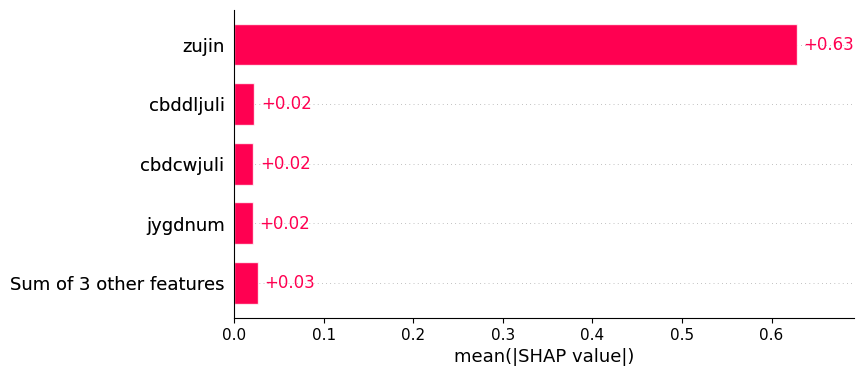

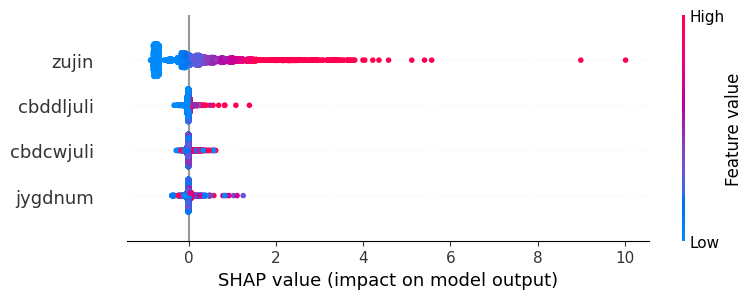

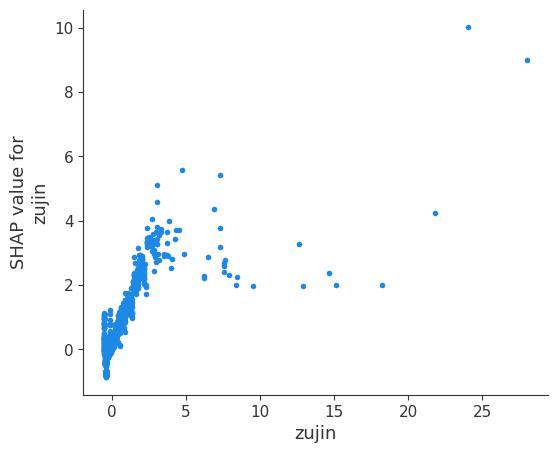

In [20]:
# 可视化 SHAP 值
# 柱状图
shap.plots.bar(shap_values2, max_display=5)

# 散点分布图
shap.summary_plot(shap_values, X, max_display=4)

# SHAP值最大的特征的shap值演变
shap.dependence_plot('zujin', shap_values, X, interaction_index=None)
